In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 75,
        x_rate = 0.5,
        m_rate = 0.6,
        weight_constraint = [-3.,3.],
        radioactive_rating = 0.5,
        grow_factor = 0.5,
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6638379273591218
Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.6666413766366465
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.6629589222095631
Checkpoint 400, Accuracy: 0.8395061728395061, Loss: 0.6631343276412399
Checkpoint 500, Accuracy: 0.845679012345679, Loss: 0.6597574022081163


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

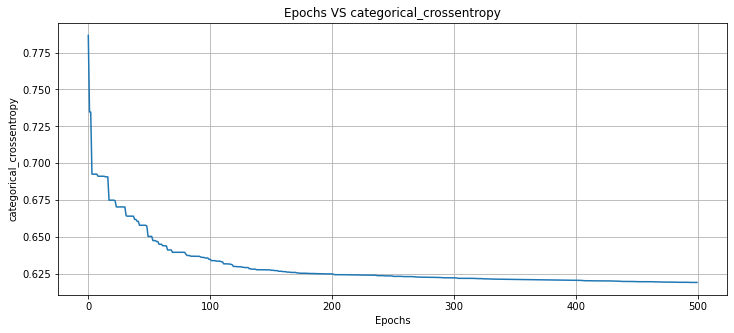

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.84638625]
 [0.10642499]
 [0.0471888 ]]
[1. 0. 0.] <-> [[0.5534118 ]
 [0.2874955 ]
 [0.15909275]]
[1. 0. 0.] <-> [[0.92750436]
 [0.05195717]
 [0.02053849]]
[0. 0. 1.] <-> [[0.6983082 ]
 [0.20126005]
 [0.1004317 ]]
[1. 0. 0.] <-> [[0.4418275 ]
 [0.34845752]
 [0.20971492]]
[1. 0. 0.] <-> [[0.8746882 ]
 [0.08762056]
 [0.03769126]]
[1. 0. 0.] <-> [[0.8882289 ]
 [0.07855299]
 [0.03321811]]
[1. 0. 0.] <-> [[0.8162617 ]
 [0.12621519]
 [0.05752308]]
[1. 0. 0.] <-> [[0.8604391 ]
 [0.09711288]
 [0.04244791]]
[1. 0. 0.] <-> [[0.91660655]
 [0.05938763]
 [0.0240059 ]]
[1. 0. 0.] <-> [[0.83129925]
 [0.11636617]
 [0.05233467]]
[1. 0. 0.] <-> [[0.8877478 ]
 [0.07887594]
 [0.03337623]]
[0. 1. 0.] <-> [[0.72946155]
 [0.1818351 ]
 [0.08870336]]
[1. 0. 0.] <-> [[0.86575174]
 [0.09357969]
 [0.04066855]]
[1. 0. 0.] <-> [[0.7818908 ]
 [0.1484957 ]
 [0.06961341]]
[0. 0. 1.] <-> [[0.00282545]
 [0.29173812]
 [0.7054364 ]]
[1. 0. 0.] <-> [[0.87154967]
 [0.08971573]
 [0.03873465]]
[1. 0. 0.] <->

In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.952912960283171, 'categorical_crossentropy': 0.6638379273591218, 'precision': 0.75, 'recall': 0.75, 'f1': 0.75, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 3}, 1: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 88, 'fn_hit': 13}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9641255931310866, 'categorical_crossentropy': 0.6666413766366465, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 21, 'tn_hit': 9, 'fn_hit': 1}, 1: {'tp_hit': 2, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 14}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.9706219116734243, 'categorical_crossentropy': 0.6629589222095631, 'precision': 0.7592592592592593, 'recall': 0.759259259

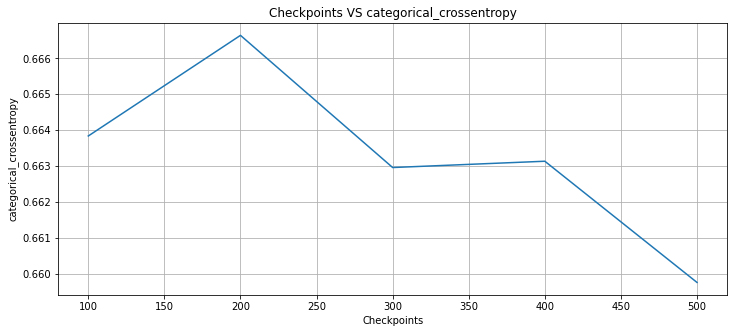

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

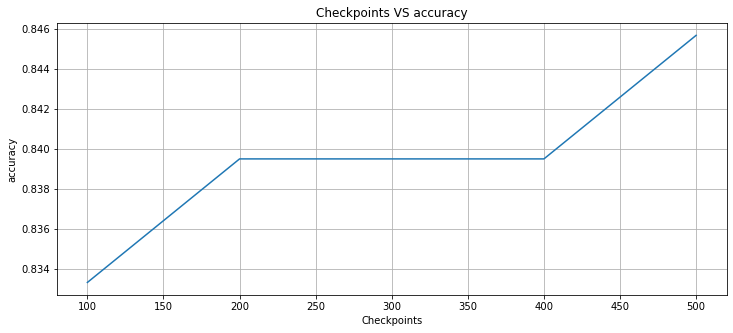

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.69658667]
 [-2.0893068 ]
 [-1.4637648 ]
 [ 1.382974  ]
 [ 0.94746023]]
 bias: [-1.9840847]

Neuron 1: weights:
[[-0.63715327]
 [ 1.48411   ]
 [-0.9021014 ]
 [ 1.2789026 ]
 [-0.29904783]]
 bias: [-1.8464268]

Neuron 2: weights:
[[-2.5270193 ]
 [ 0.03149672]
 [-0.570929  ]
 [ 0.26980844]
 [ 1.7064443 ]]
 bias: [2.3497093]

Neuron 3: weights:
[[-0.5245796]
 [-1.5136883]
 [ 0.5553545]
 [ 1.719753 ]
 [ 0.4752301]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[ 1.301227 ]
 [-1.5353004]
 [ 1.4257529]
 [-1.685155 ]]
 bias: [0.03227558]

Neuron 1: weights:
[[-1.9803934]
 [ 1.3942652]
 [-0.7175295]
 [ 1.4011347]]
 bias: [0.32055432]

Neuron 2: weights:
[[-2.5524569 ]
 [ 0.04880611]
 [-2.7754593 ]
 [ 3.        ]]
 bias: [1.6386983]

$

